In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [41]:
pip install ucimlrepo

In [42]:
from ucimlrepo import fetch_ucirepo
rt_iot2022 = fetch_ucirepo(id=942)

# Data
X = rt_iot2022.data.features
y = rt_iot2022.data.targets


In [43]:
df = pd.concat([X, y], axis=1)  # Make sure y is a Series or adjust accordingly

# Check the first few rows of the dataframe
print(df.head())

# Encoder for the 'Attack_type' column
encoder = LabelEncoder()
df['Attack_type'] = encoder.fit_transform(df['Attack_type'])
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols)

# Split data into features and target
X = df.drop('Attack_type', axis=1).values
y = to_categorical(df['Attack_type'].values)  # One-hot encode the target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

   id.orig_p  id.resp_p proto service  flow_duration  fwd_pkts_tot  \
0      38667       1883   tcp    mqtt      32.011598             9   
1      51143       1883   tcp    mqtt      31.883584             9   
2      44761       1883   tcp    mqtt      32.124053             9   
3      60893       1883   tcp    mqtt      31.961063             9   
4      51087       1883   tcp    mqtt      31.902362             9   

   bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  ...  \
0             5                  3                  3          0.281148  ...   
1             5                  3                  3          0.282277  ...   
2             5                  3                  3          0.280164  ...   
3             5                  3                  3          0.281593  ...   
4             5                  3                  3          0.282111  ...   

   active.std     idle.min     idle.max     idle.tot     idle.avg  idle.std  \
0         0.0  2972

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Build the model
model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(y_train.shape[1], activation='softmax')  # Output layer with softmax for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [45]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)


Epoch 1/20
1155/1155 [==============================] - 15s 11ms/step - loss: 0.1332 - accuracy: 0.9650 - val_loss: 0.0380 - val_accuracy: 0.9885
Epoch 2/20
1155/1155 [==============================] - 12s 11ms/step - loss: 0.0458 - accuracy: 0.9852 - val_loss: 0.0303 - val_accuracy: 0.9916
Epoch 3/20
1155/1155 [==============================] - 12s 10ms/step - loss: 0.0376 - accuracy: 0.9882 - val_loss: 0.0325 - val_accuracy: 0.9909
Epoch 4/20
1155/1155 [==============================] - 12s 11ms/step - loss: 0.0301 - accuracy: 0.9904 - val_loss: 0.0341 - val_accuracy: 0.9923
Epoch 5/20
1155/1155 [==============================] - 12s 10ms/step - loss: 0.0289 - accuracy: 0.9903 - val_loss: 0.0239 - val_accuracy: 0.9933
Epoch 6/20
1155/1155 [==============================] - 12s 11ms/step - loss: 0.0245 - accuracy: 0.9924 - val_loss: 0.0230 - val_accuracy: 0.9949
Epoch 7/20
1155/1155 [==============================] - 12s 10ms/step - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.0210 -

In [46]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


770/770 [==============================] - 2s 3ms/step - loss: 0.0328 - accuracy: 0.9947
Test Accuracy: 0.9947, Test Loss: 0.0328


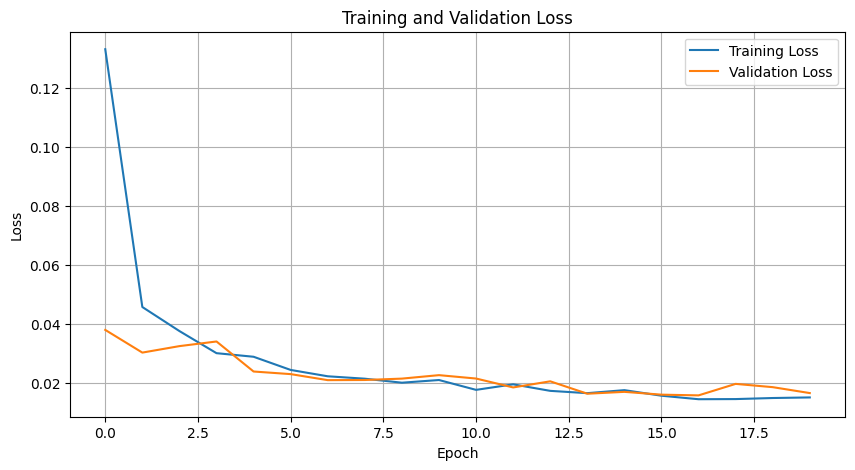

In [50]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



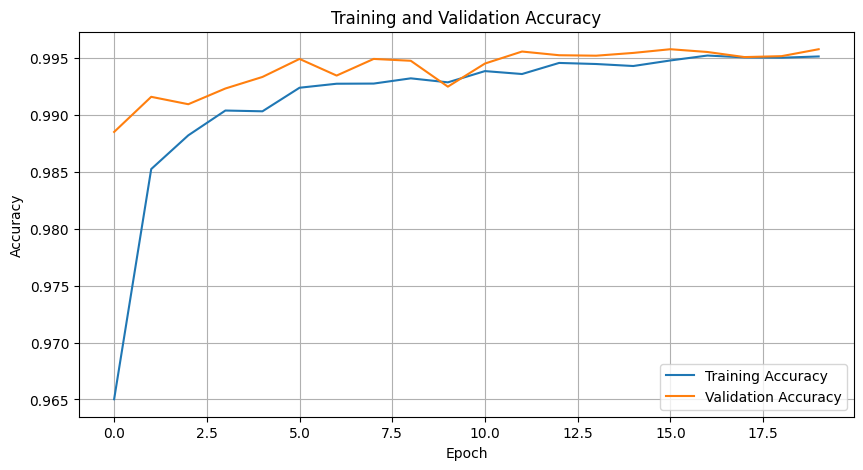

In [52]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

770/770 [==============================] - 2s 2ms/step


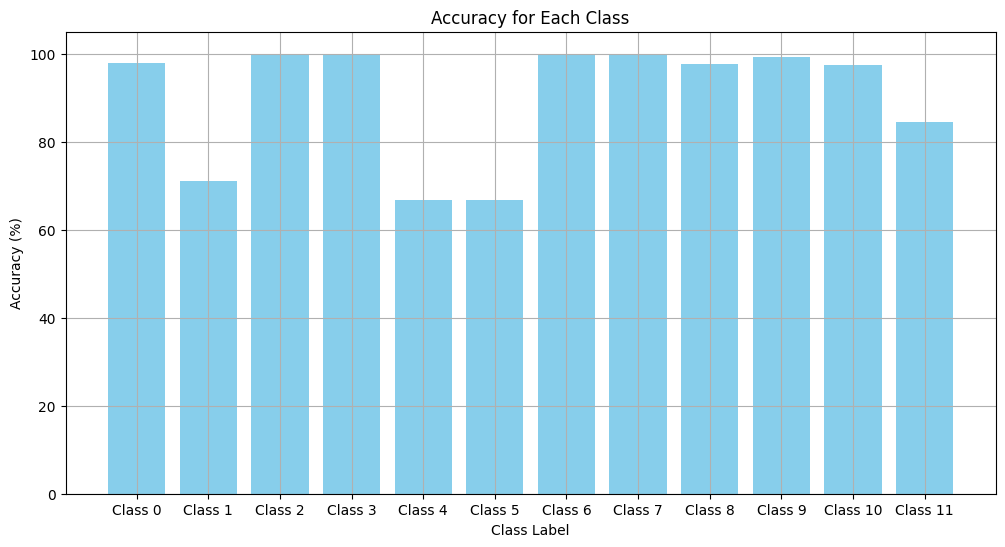

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict the probabilities for each class
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
class_accuracy = 100 * cm.diagonal() / cm.sum(axis=1)  # Calculate accuracy per class in percentage

# Plotting accuracy per class
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_accuracy)), class_accuracy, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Each Class')
plt.xticks(ticks=range(len(class_accuracy)), labels=[f'Class {i}' for i in range(len(class_accuracy))])  # Adjust labels as needed
plt.grid(True)
plt.show()
